# Driver and engine performance impact on F1 race results

Łukasz Filo, Klaudiusz Grobelski

## Problem formulation [0-5 pts]:

- is the problem clearly stated [1 pt]
- what is the point of creating model, are potential use cases defined [1 pt]
- where do data comes from, what does it containt [1 pt]
- DAG has been drawn [1 pt]
- confoundings (pipe, fork, collider) were described [1 pt]

In this notebook, we will develop a Bayesian multilevel binomial regression model to predict driver performance across recent Formula 1 seasons. Specifically, we will use data from the 2019–2024 seasons. The input data includes information about drivers, constructors, and engine suppliers used by each team. The primary objective of this analysis is to understand and predict how various factors—such as driver skill, team changes, and engine suppliers—affect driver performance over time. This model could assist teams in making strategic decisions, such as evaluating whether changes in drivers or engine suppliers might enhance performance. It may also be valuable to fans and analysts seeking to assess the relative impact of technical and human factors on race results.

We use historical race data sourced from FastF1, which includes finishing positions, lap times, and team-driver pairings for each race. Driver skill ratings are obtained from the EA Sports F1 game, while engine usage data (i.e., which power unit each constructor used in a given season) is collected from Wikipedia, covering the 2019–2024 period.

To gain a clearer understanding of the relationships between variables and to identify potential sources of bias, we will construct a Directed Acyclic Graph (DAG).

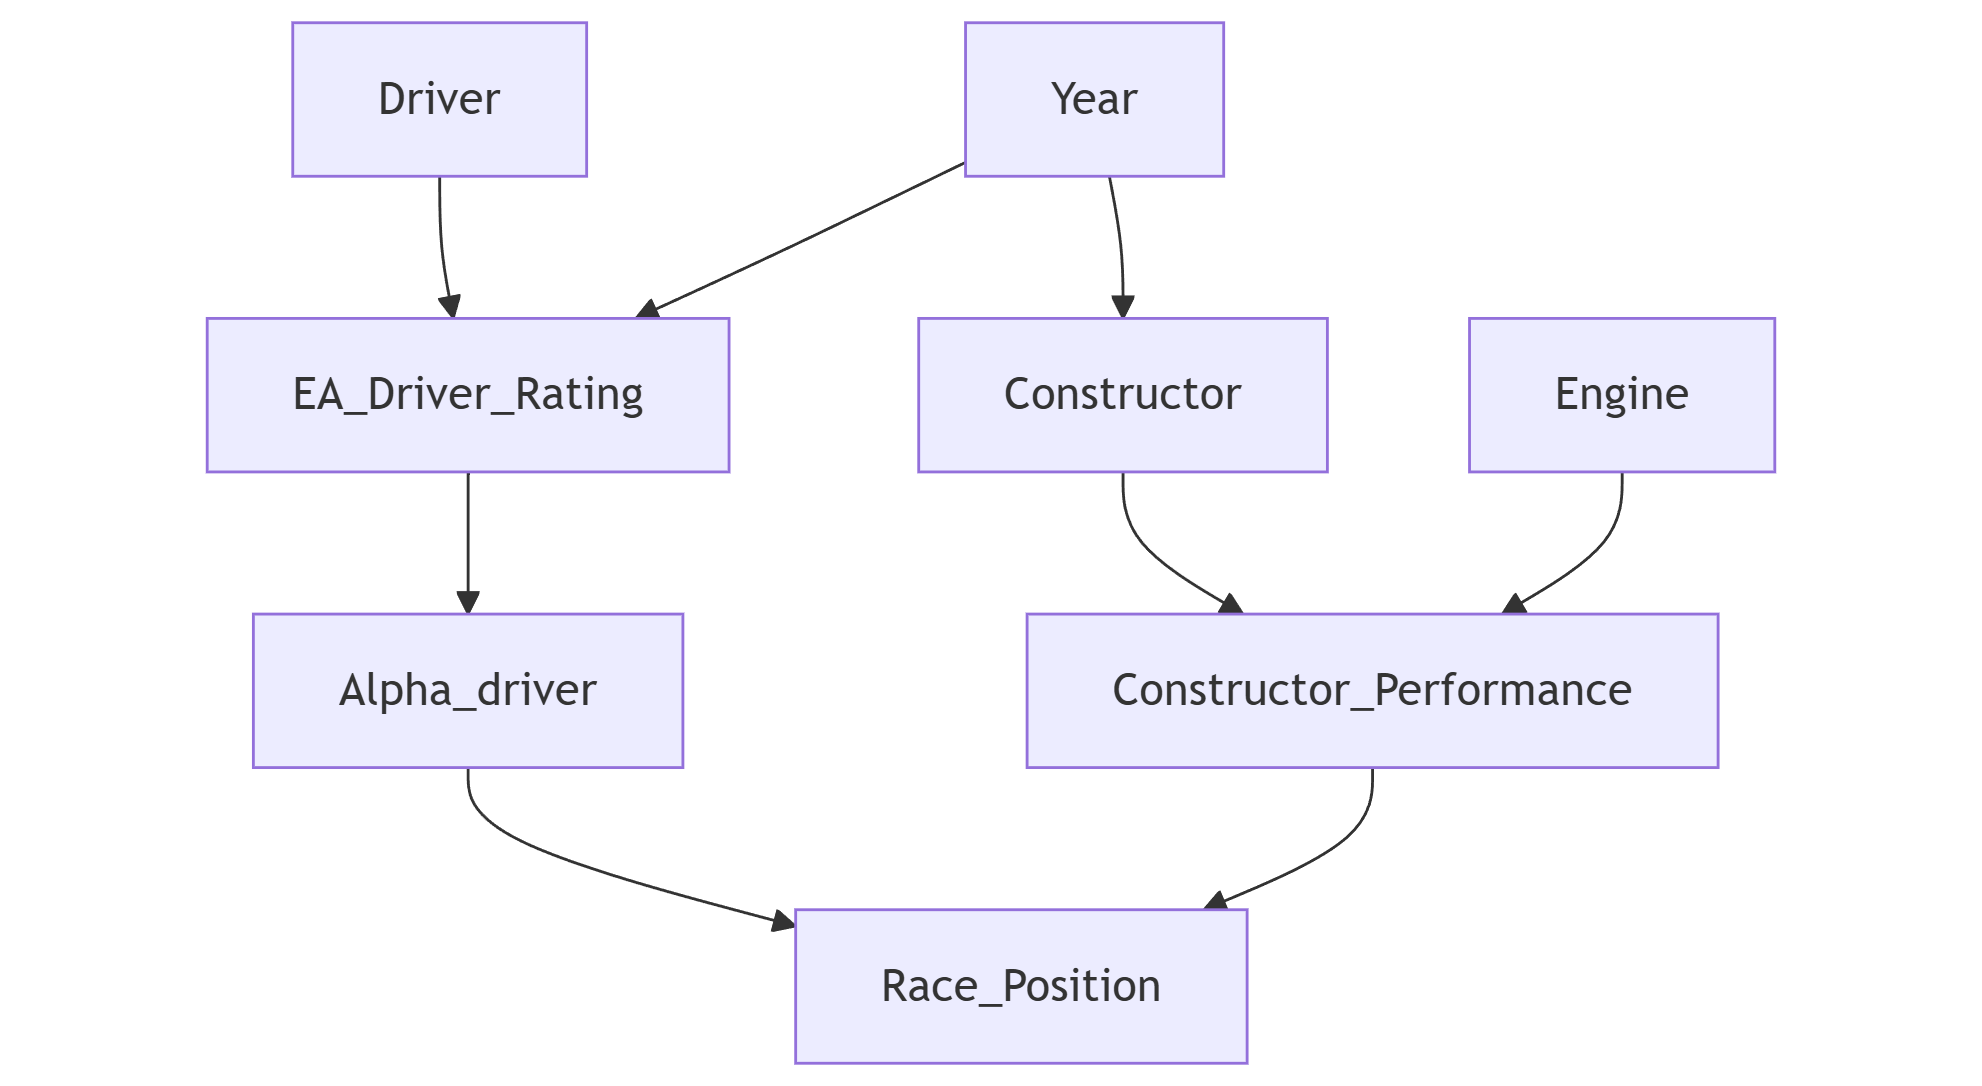

In [1]:
from IPython.display import Image
Image("images/DAG.png")

Why these data were used:

**EA Driver Rating** – an independent, available measure of skill that helps avoid subjective assessments.

**Engine, Constructor** – technical foundations influencing the result, with a clear causal meaning.

**Year + Constructor** – capturing variability between seasons.

We omitted data such as weather, which could cause irregular effects on the model, since races in difficult conditions are hard to predict. The number of pit stops was also excluded because, in a typical race, most teams perform the same number of pit stops, or there are cases where a driver can earn an extra point for the fastest lap. If the team knows they won’t catch the driver ahead or lose position, they may perform this tactical maneuver. However, an increased number of pit stops often occurs due to collisions during the race, meaning the driver might have more pit stops but a significantly lower position. This could confuse the model’s behavior.

DAGs illustrate the main types of confounding structures:

- **Pipe:** e.g., `Engine → Constructor_Performance → Race_Position` – the engine affects the constructor’s performance, which in turn influences the race position.

- **Fork:** e.g., `Year → EA_Driver_Rating` and `Year → Constructor` – the year influences the driver rating (if drivers performed well that year, they have a higher rating) and also affects constructors due to changing vehicle regulations each season.

- **Collider:** `Alpha_driver → Race_Position ← Constructor_Performance` – race outcome depends on both the team’s quality building the car and the skill of the driver racing it.


In [2]:
import numpy as np
from cmdstanpy import CmdStanModel
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az

# import logging
# logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

## Data preprocessing [0-2 pts]:
- is preprocessing step clearly described [1 pt]
- reasoning and types of actions taken on the dataset have been described [1 pt]

In [3]:
df = pd.read_csv('data/processed_data/data.csv')
unique_drivers = df['DriverId'].unique()
driver_id_map = {driver: idx + 1 for idx, driver in enumerate(unique_drivers)}
df['DriverId'] = df['DriverId'].map(driver_id_map)
drivers = df['DriverId'].values

unique_team = df['TeamId'].unique()
team_id_map = {team: idx + 1 for idx, team in enumerate(unique_team)}
df['TeamId'] = df['TeamId'].map(team_id_map)
teams = df['TeamId'].values

unique_engine = df['Engine'].unique()
engine_id_map = {engine: idx + 1 for idx, engine in enumerate(unique_engine)}
df['Engine'] = df['Engine'].map(engine_id_map)
engines = df['Engine'].values

unique_season = df['Season'].unique()
season_id_map = {season: idx + 1 for idx, season in enumerate(unique_season)}
df['Season'] = df['Season'].map(season_id_map)
seasons = df['Season'].values


df['Rating_all'] = (df['Rating'] - df['Rating'].mean()) / df['Rating'].std()
ratings = df['Rating'].values

In [6]:
def standardize_group(group):
    mean = group['Rating'].mean()
    std = group['Rating'].std()
    group['Rating_by_year'] = (group['Rating'] - mean) / std
    return group

df = df.groupby('Season', group_keys=False, observed=True).apply(standardize_group)
ratings_by_year = df["Rating_by_year"].values
df['Position'] = df['Position'].astype(int)

/tmp/ipykernel_331/975955920.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Season', group_keys=False, observed=True).apply(standardize_group)


In our model, we applied two approaches to standardizing driver rating data. In the first case, standardization was performed on the entire dataset, while in the second, it was done separately for each season.

In [7]:
order_col = ['DriverId', 'Rating_by_year', 'Rating_all', 'TeamId', 'Engine', 'Season','Position']
df = df[order_col]
df.head()

,DriverId,Rating_by_year,Rating_all,TeamId,Engine,Season,Position
0,1,1.212000,0.872743,1,1,1,1
1,2,0.623188,0.259732,2,2,1,2
2,3,-0.407232,-0.813038,3,3,1,3
3,4,1.800812,1.485754,1,1,1,4
4,5,0.034377,-0.353279,3,3,1,5


## Model [0-4 pts]
- are two different models specified [1 pt]
- are difference between two models explained [1 pt]
- is the difference in the models justified (e.g. does adding aditional parameter makes sense? ) [1 pt]
- are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt]

### Model 1  
  $$
  \text{model} = \alpha_{\text{constructor}} - \alpha_{\text{driver}} \cdot \text{Driver Rating}
  $$

  $$
  \theta = \mathrm{inv\_logit}(\text{model}) = \frac{1}{1 + e^{-\text{model}}}
  $$

  $$
  \text{position} \sim \mathrm{Binomial}(n=19, p=\theta)
  $$


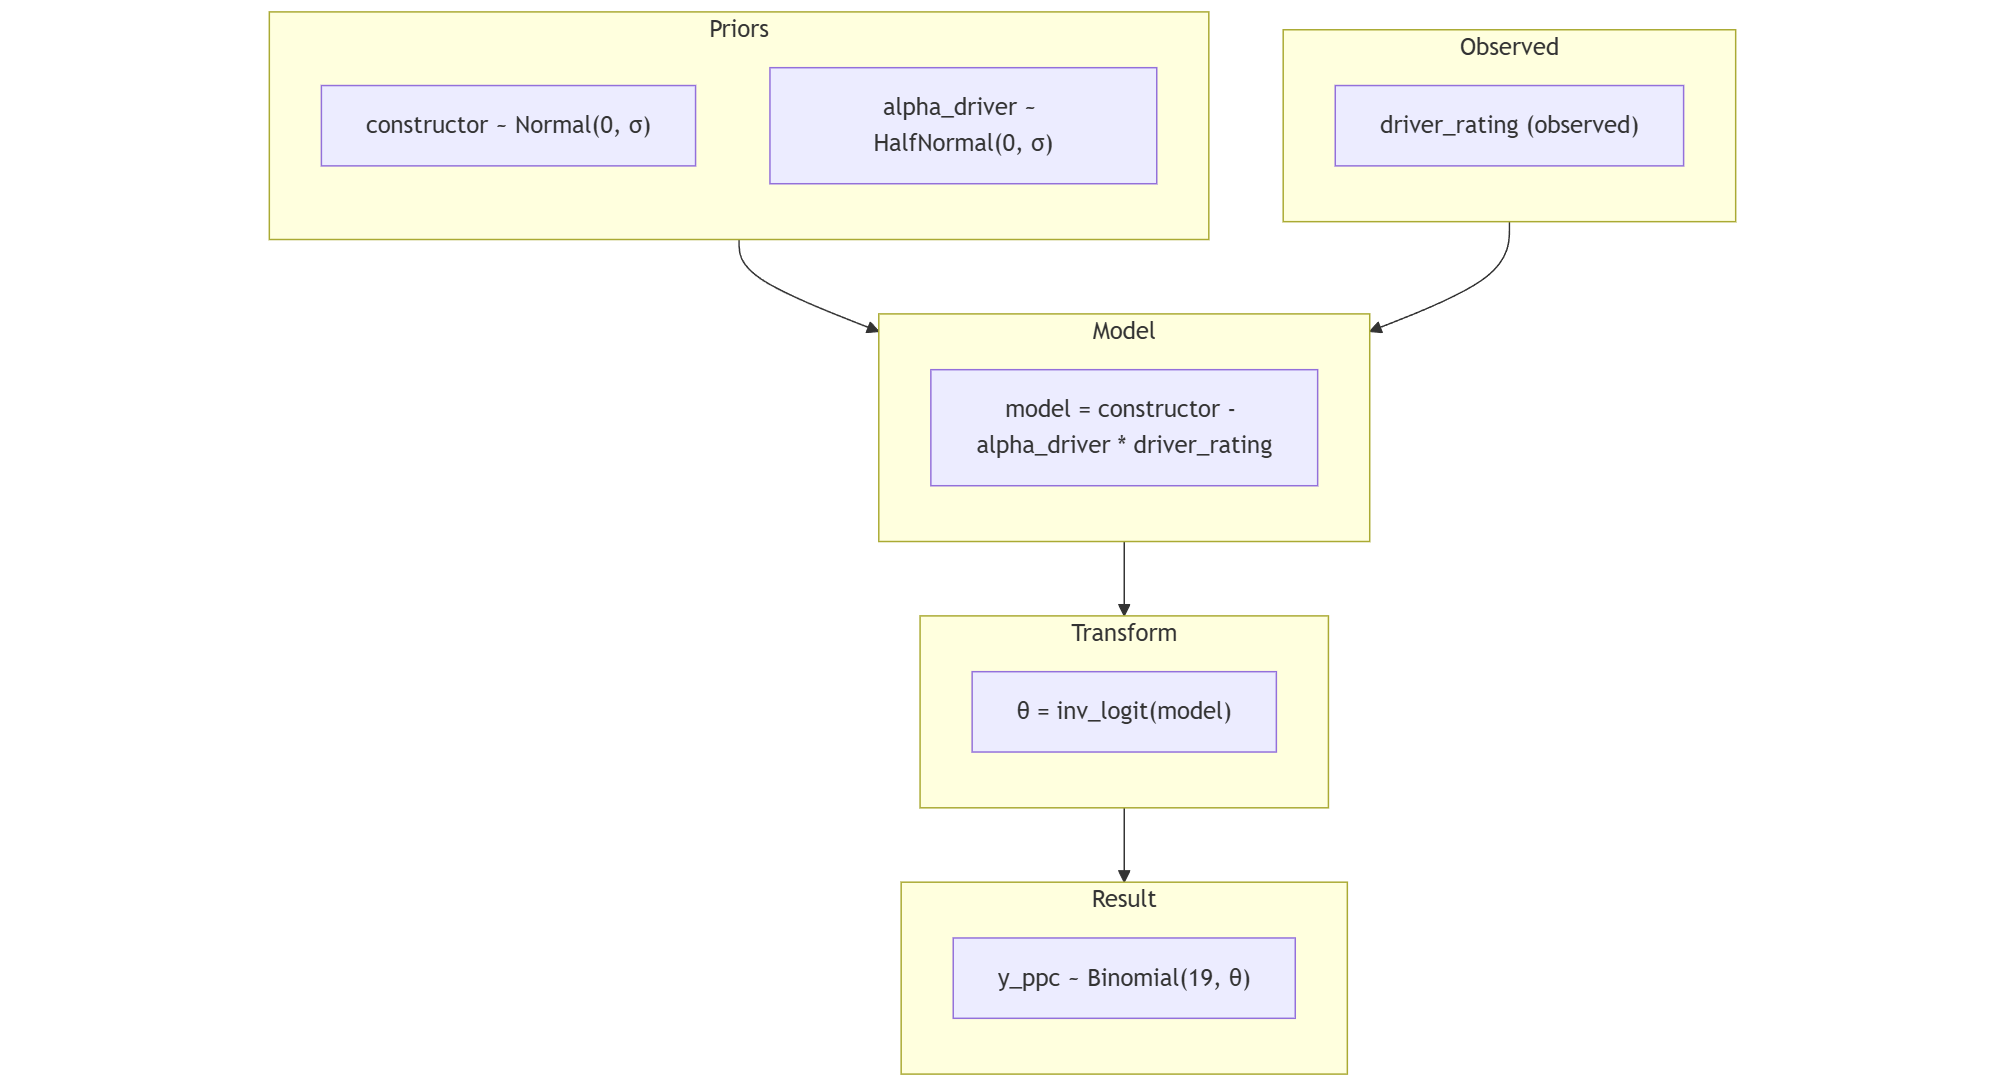

In [8]:
Image("images/model_1_DAG.png")

### Parameters

- **Constructor** – represents the strength of the team. It can be interpreted as a deviation from the average constructor:

    - **Negative values** → better than average car  
    - **Positive values** → worse than average car  

- **Alpha_Driver** - Coefficient determining how much impact the driver has on the performance.

- **Driver_Rating** - Driver's rating, taken from the EA Sports F1 video game.


### Model 2
  $$
  \text{model} = \alpha_{\text{engine}} + \alpha_{\text{constructor}} - \alpha_{\text{driver}} \cdot \text{Driver Rating}
  $$

  $$
  \theta = \mathrm{inv\_logit}(\text{model}) = \frac{1}{1 + e^{-\text{model}}}
  $$

  $$
  \text{position} \sim \mathrm{Binomial}(n=19, p=\theta)
  $$


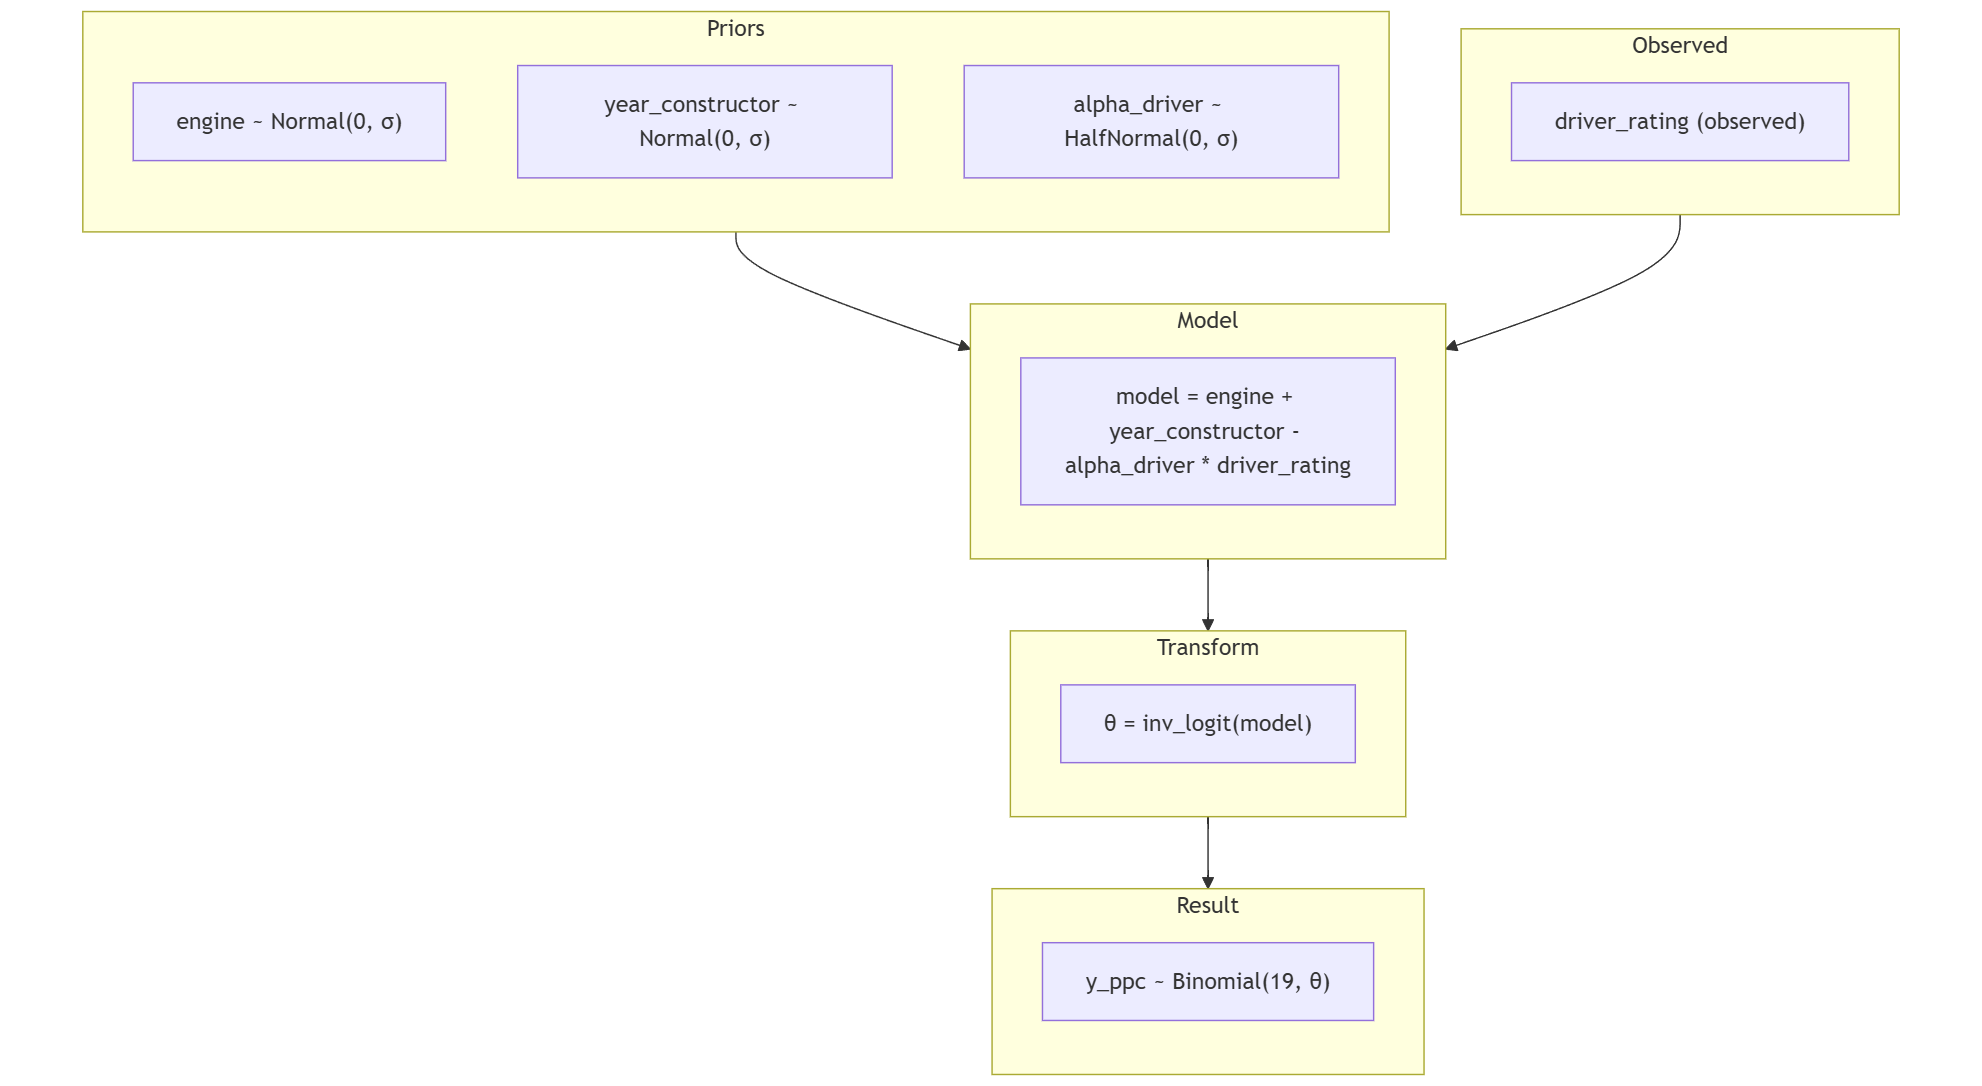

In [9]:
Image("images/model_2_DAG.png")

### Parameters

- **Constructor** - Represents the team's strength for a given season. It can be interpreted as a deviation from the average constructor:

    - **Negative values** → better than average car  
    - **Positive values** → worse than average car  

- **Engine** - Represents the engine used:
    - **Negative values** → better than average engine  
    - **Positive values** → worse than average engine  


- **Alpha_Driver** - Coefficient determining how much impact the driver has on the performance.

- **Driver_Rating** - Driver's rating, taken from the EA Sports F1 video game.


### Difference between the models

The difference between the first and the second model is based on two main factors. The first is the inclusion of information about the engine manufacturer used by each team. In Formula 1, there are several engine suppliers, and incorporating this parameter allows the analysis to assess how a change in engine supplier affected a team's performance. The second distinguishing factor is the inclusion of temporal parameters. In the first model, we assume that a team is generally strong or weak, whereas in the second model, we account for variations in team performance across different seasons. A well-known example for any fan is the Mercedes team, which dominated from 2014 to 2021 by winning the Constructors' Championships, but has seen a decline in performance since the 2022 season. Differences in how data is fed into the models also result from the different standardization methods used.

### Required Data

- Team performance data across multiple seasons (e.g., race results).  
- Identification of constructor for each team and season.  
- Engine manufacturer information for each team and season.
- Driver rating data taken from the F1 game developed by EA Sports.

## Priors [0-4 pts]
- Is it explained why particular priors for parameters were selected [1 pt]
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt]

## The Prior tests were prepared for the best, average, and weakest driver.

### Model 1 PPC

In [10]:
model_1_ppc = CmdStanModel(stan_file='stan/model_1_ppc.stan')

In [11]:
def draw_plots_ppc_model_1(sigmas, driver_rating):
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    colors = ["#130582", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

    for s_i in range(3):
        sigma = {'sigma': sigmas[s_i], 'driver_rating': driver_rating}
        model_1_ppc_sim = model_1_ppc.sample(data=sigma, iter_warmup=1, fixed_param=True, seed=25062025)
        
        axes[s_i, 0].hist(model_1_ppc_sim.stan_variable('alpha_driver').flatten(), bins=100, density=True, color=colors[1], alpha=0.8)
        axes[s_i, 0].set_yticks([])
        axes[s_i, 0].set_title(f'alpha_driver ~ Normal(0, {sigmas[s_i]})', fontweight='bold')

        axes[s_i, 1].hist(model_1_ppc_sim.stan_variable('constructor').flatten(), bins=100, density=True, color=colors[2], alpha=0.8)
        axes[s_i, 1].set_yticks([])
        axes[s_i, 1].set_title(f'constructor ~ Normal(0, {sigmas[s_i]})', fontweight='bold')

        axes[s_i, 2].hist(model_1_ppc_sim.stan_variable('theta').flatten(), bins=100, density=True, color=colors[4], alpha=0.8)
        axes[s_i, 2].set_yticks([])
        axes[s_i, 2].set_title('theta = constructor - alpha_driver * driver_rating', fontweight='bold')

        positions = model_1_ppc_sim.stan_variable('y_ppc').flatten() + 1
        n_bins = np.arange(22) - 0.5
        axes[s_i, 3].hist(positions, bins=n_bins, rwidth=0.85, density=True, color=colors[5], alpha=0.85, label="Simulated Positions")
        axes[s_i, 3].set_xticks(range(22))
        axes[s_i, 3].set_xlim([0, 21])
        axes[s_i, 3].set_yticks([])
        axes[s_i, 3].set_title('Position', fontweight='bold')

    for i in range(4):
        axes[2, i].set_xlabel(['alpha_driver', 'year_constructor', 'theta', 'Position'][i], fontsize=13, fontweight='bold')

    for ax_row in axes:
        for ax in ax_row:
            ax.tick_params(axis='both', which='major', labelsize=11)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    fig.suptitle("Prior Predictive Checks for Model 1", fontsize=18, fontweight='bold')
    fig.tight_layout(pad=2.0)
    plt.show()

In [14]:
sigmas = [0.6, 0.8, 1]

#### The driver with the best results.

17:34:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:34:48 - cmdstanpy - INFO - CmdStan done processing.
17:34:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:34:48 - cmdstanpy - INFO - CmdStan done processing.
17:34:48 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:34:48 - cmdstanpy - INFO - CmdStan done processing.


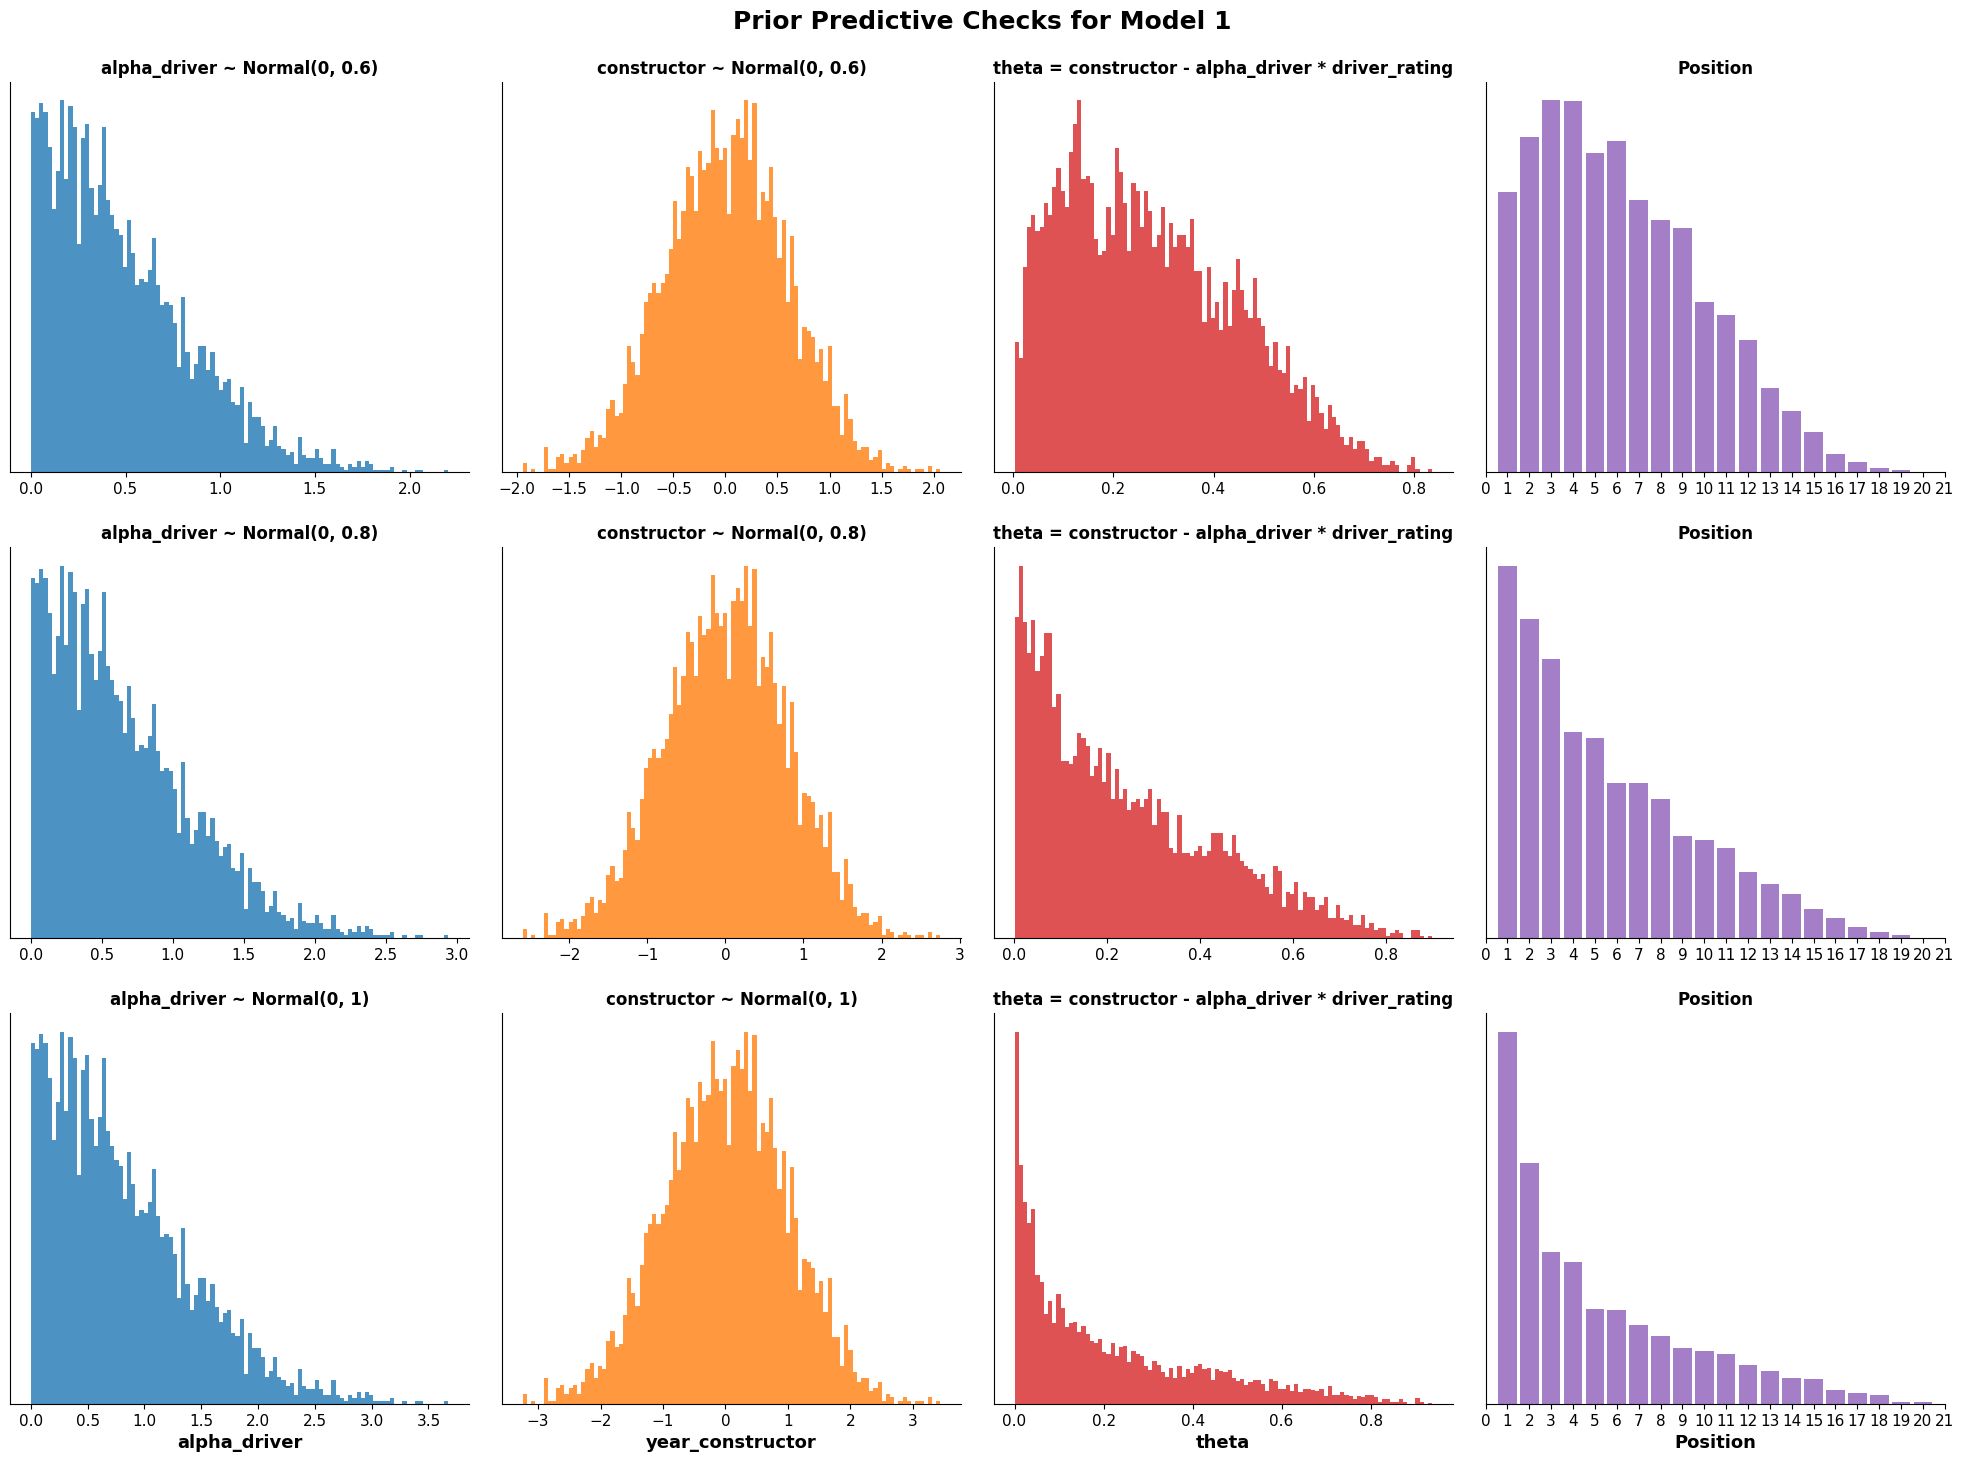

In [15]:
driver_rating = 2.5

draw_plots_ppc_model_1(sigmas, driver_rating)

#### The driver with the average results.

17:34:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:34:55 - cmdstanpy - INFO - CmdStan done processing.
17:34:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:34:55 - cmdstanpy - INFO - CmdStan done processing.
17:34:55 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:34:55 - cmdstanpy - INFO - CmdStan done processing.


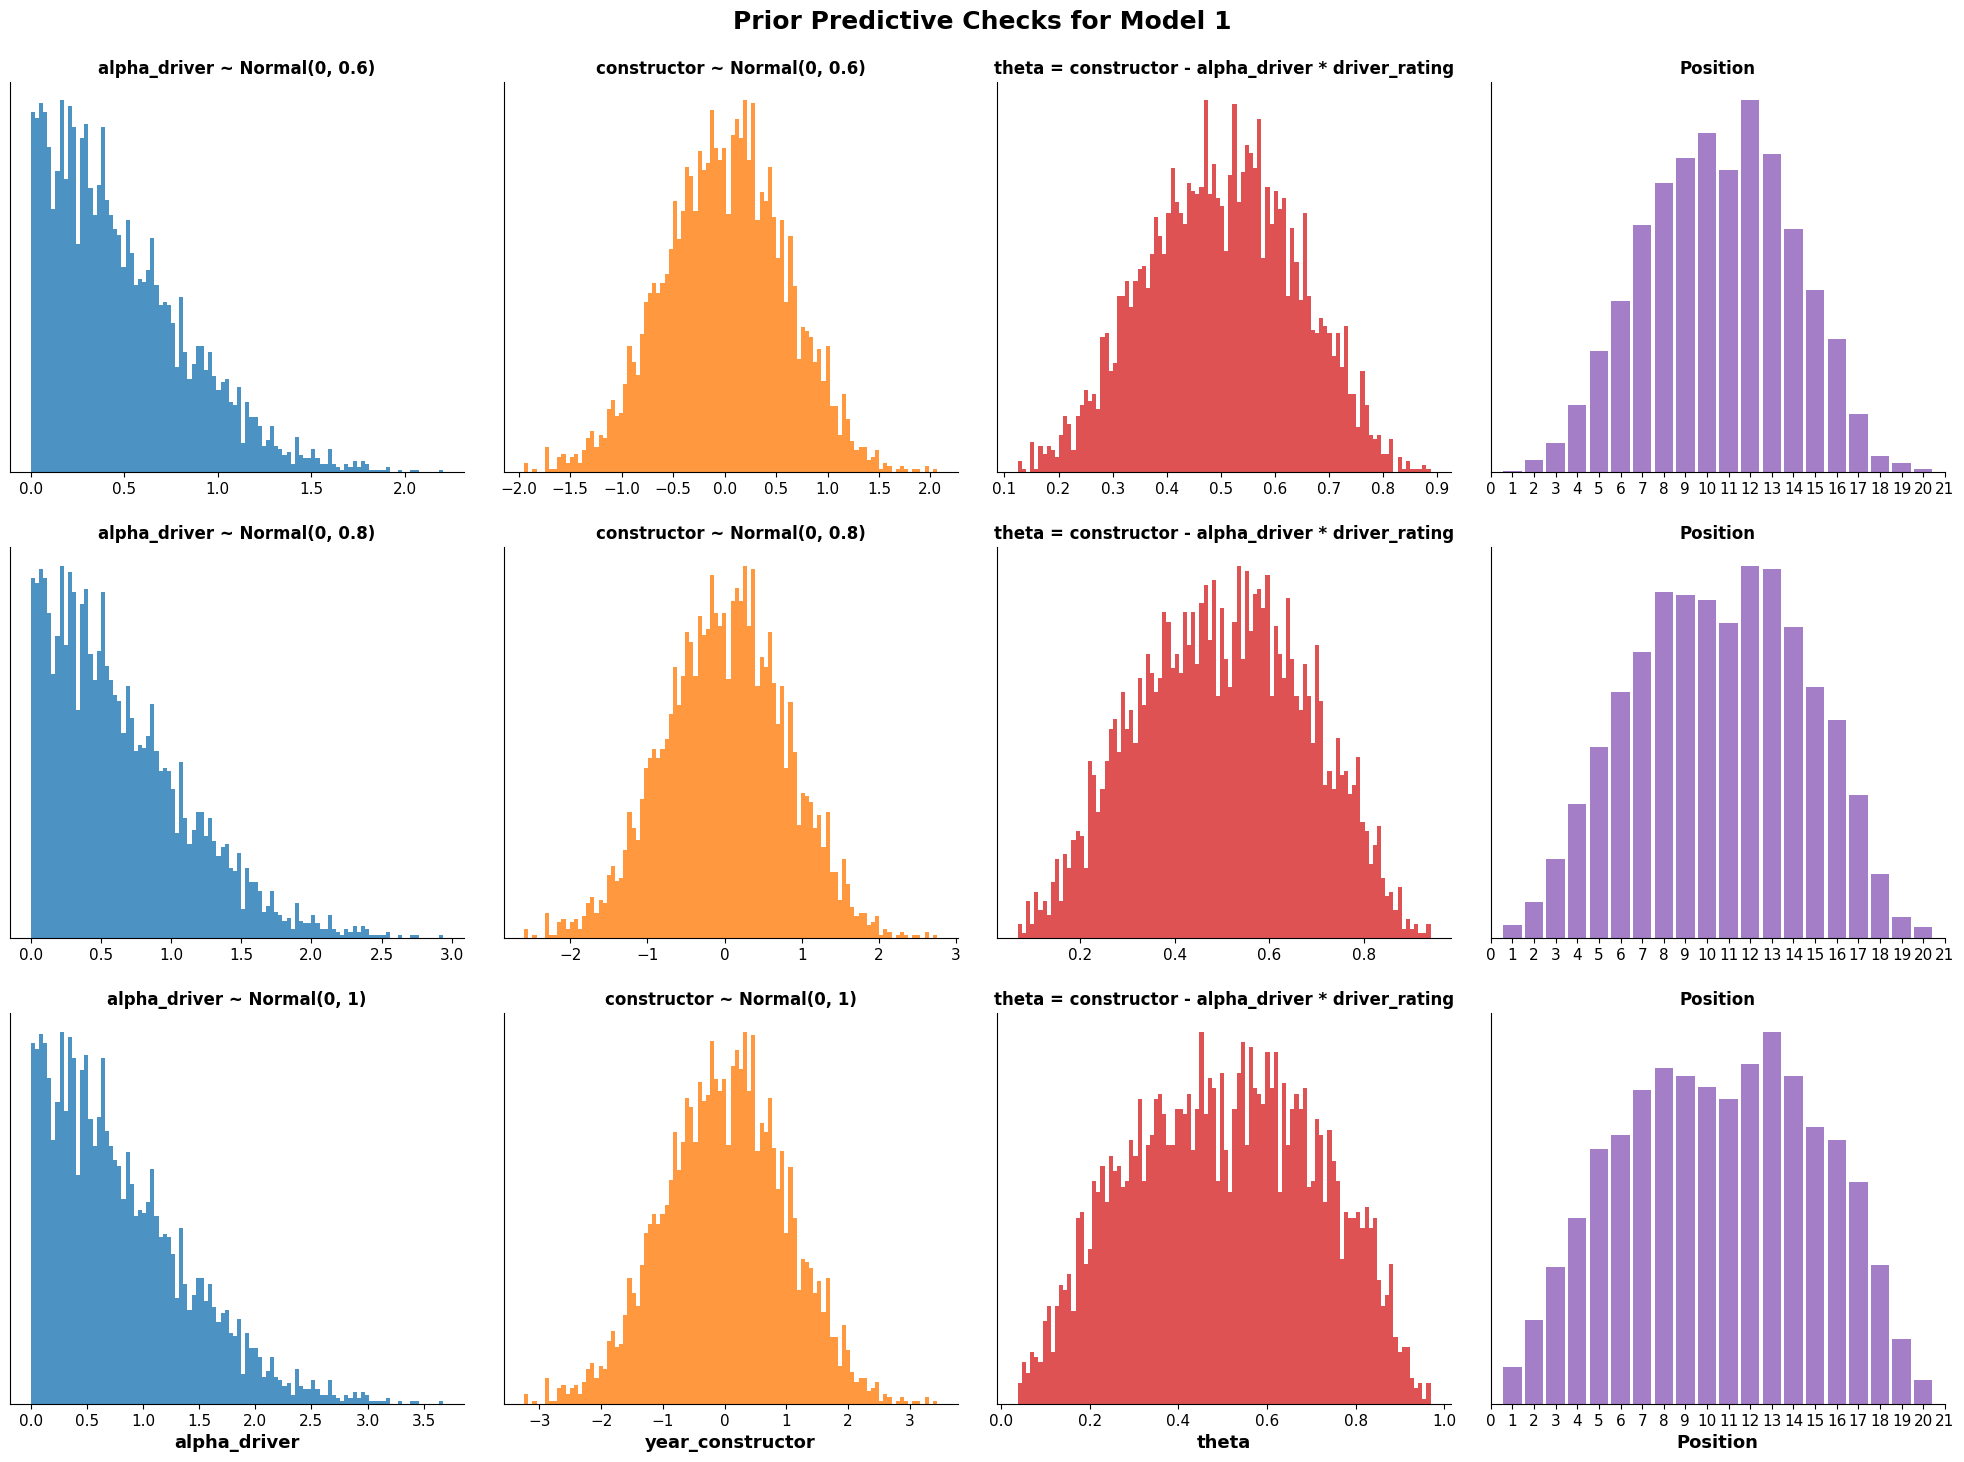

In [16]:
driver_rating = 0

draw_plots_ppc_model_1(sigmas, driver_rating)

#### The driver with the weakest results.

17:35:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:00 - cmdstanpy - INFO - CmdStan done processing.
17:35:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:00 - cmdstanpy - INFO - CmdStan done processing.
17:35:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:00 - cmdstanpy - INFO - CmdStan done processing.


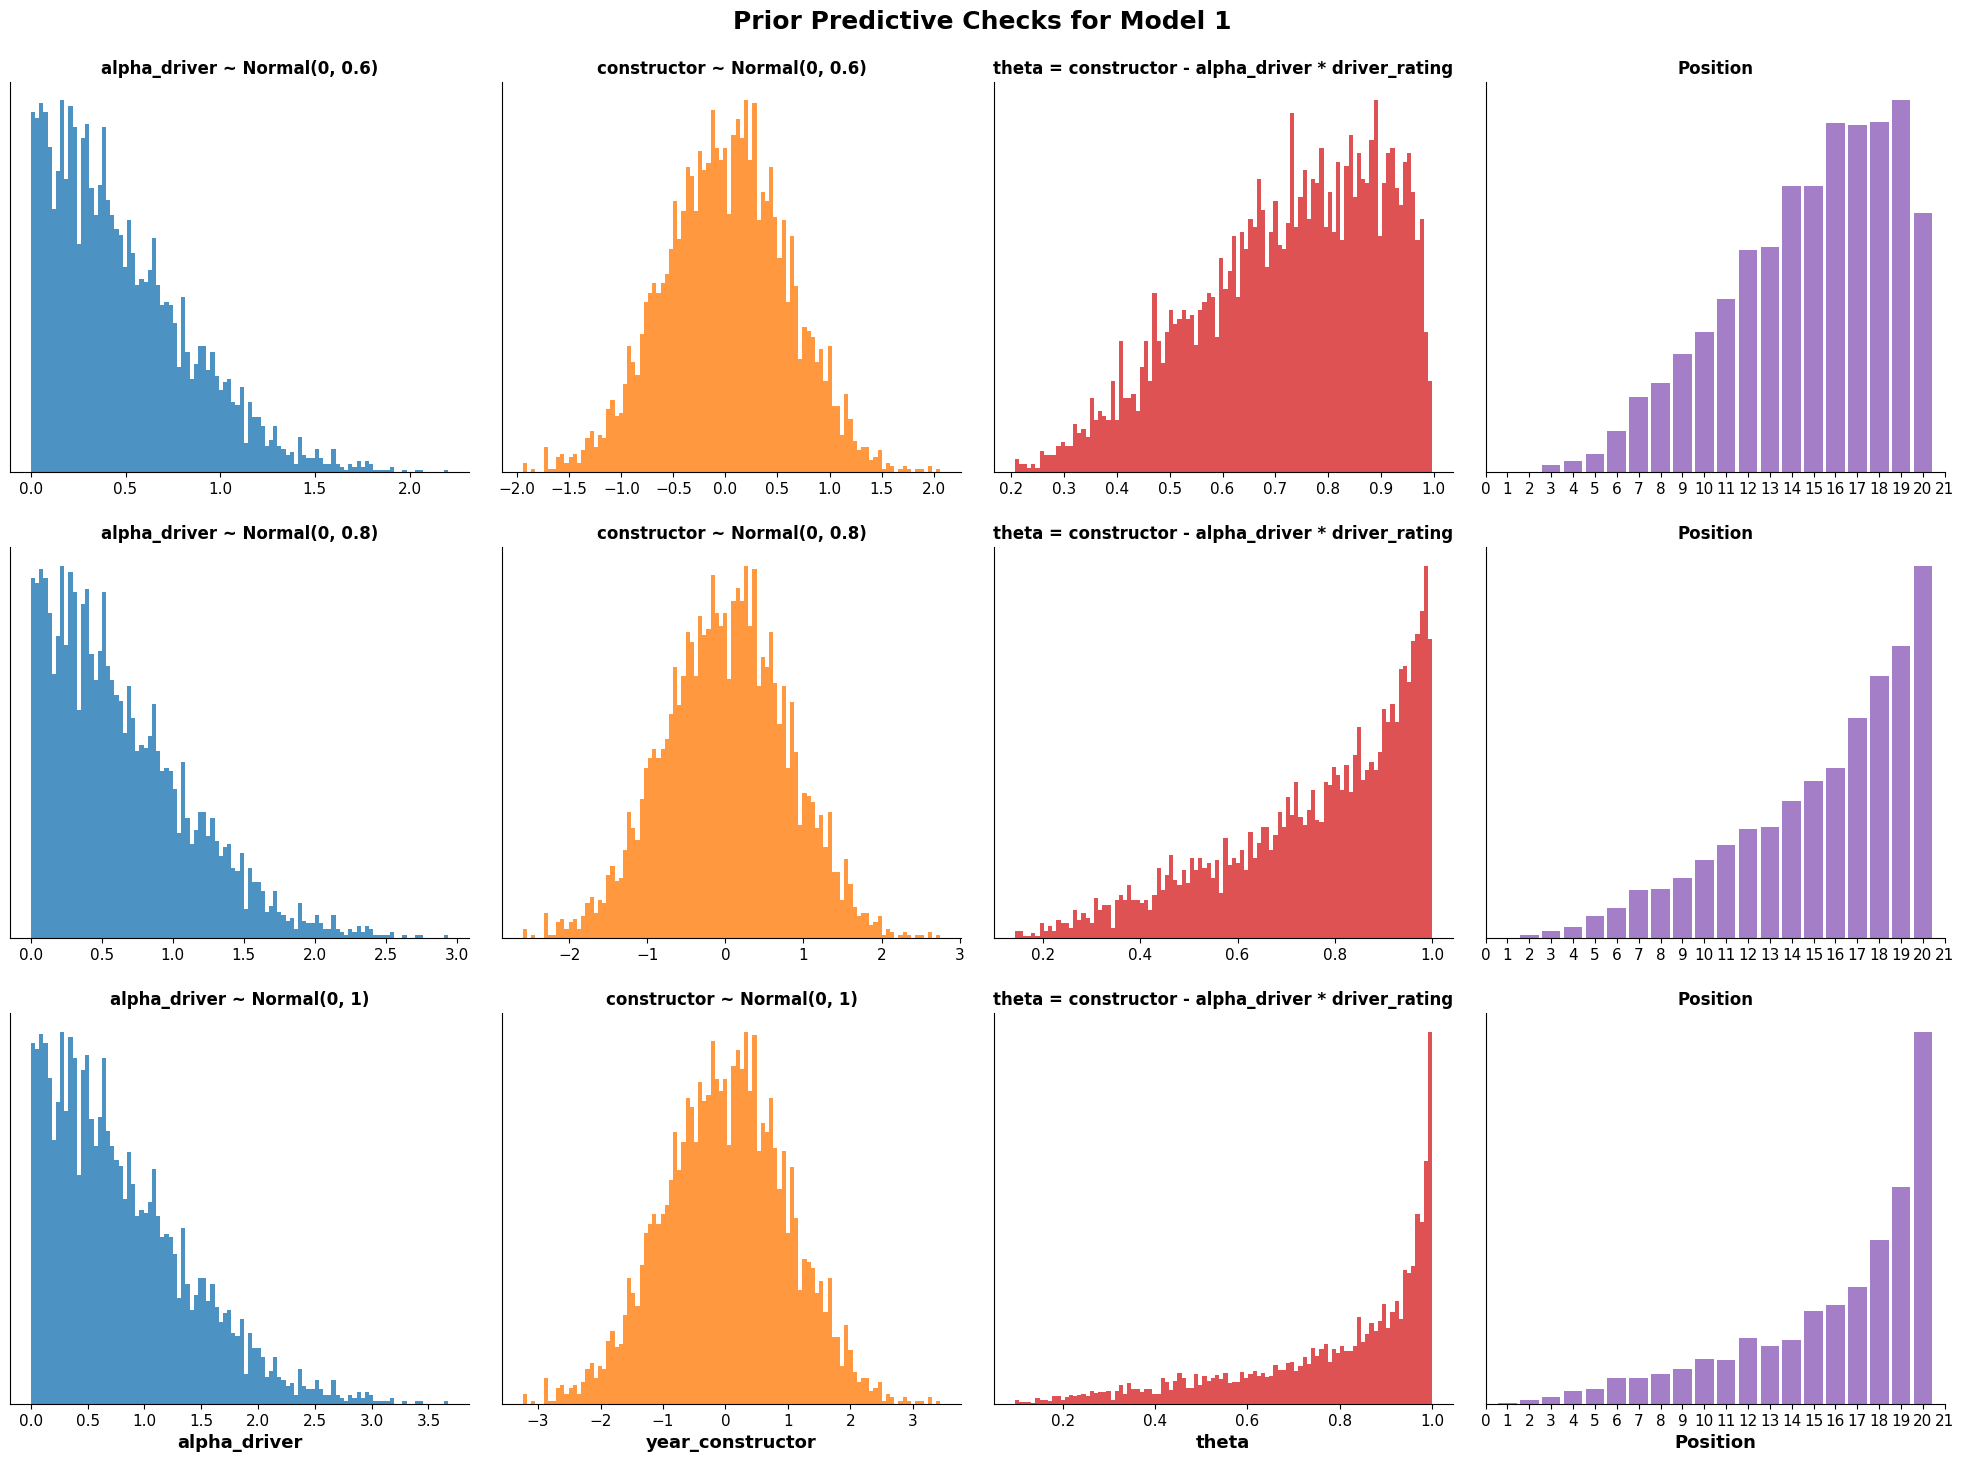

In [17]:
driver_rating = -2.5

draw_plots_ppc_model_1(sigmas, driver_rating)

### Model 2 PPC

In [18]:
model_2_ppc = CmdStanModel(stan_file='stan/model_2_ppc.stan')

In [19]:
def draw_plots_ppc_model_2(sigmas, driver_rating):
    fig, axes = plt.subplots(3, 5, figsize=(24, 15))
    colors = ["#130582", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

    for s_i in range(3):
        sigma = {'sigma': sigmas[s_i], 'driver_rating': driver_rating}
        model_2_ppc_sim = model_2_ppc.sample(data=sigma, iter_warmup=1, fixed_param=True, seed=25062025)

        axes[s_i, 0].hist(model_2_ppc_sim.stan_variable('engine').flatten(), bins=100, density=True, color=colors[0], alpha=0.8)
        axes[s_i, 0].set_yticks([])
        axes[s_i, 0].set_title(f'engine ~ Normal(0, {sigmas[s_i]})', fontweight='bold')

        axes[s_i, 1].hist(model_2_ppc_sim.stan_variable('alpha_driver').flatten(), bins=100, density=True, color=colors[1], alpha=0.8)
        axes[s_i, 1].set_yticks([])
        axes[s_i, 1].set_title(f'alpha_driver ~ Normal(0, {sigmas[s_i]})', fontweight='bold')

        axes[s_i, 2].hist(model_2_ppc_sim.stan_variable('year_constructor').flatten(), bins=100, density=True, color=colors[2], alpha=0.8)
        axes[s_i, 2].set_yticks([])
        axes[s_i, 2].set_title(f'year_constructor ~ Normal(0, {sigmas[s_i]})', fontweight='bold')

        axes[s_i, 3].hist(model_2_ppc_sim.stan_variable('theta').flatten(), bins=100, density=True, color=colors[4], alpha=0.8)
        axes[s_i, 3].set_yticks([])
        axes[s_i, 3].set_title('theta = engine + alpha_constructor_year \n - alpha_driver * driver_rating', fontweight='bold')

        positions = model_2_ppc_sim.stan_variable('y_ppc').flatten() + 1
        n_bins = np.arange(22) - 0.5
        axes[s_i, 4].hist(positions, bins=n_bins, rwidth=0.85, density=True, color=colors[5], alpha=0.85, label="Simulated Positions")
        axes[s_i, 4].set_xticks(range(22))
        axes[s_i, 4].set_xlim([0, 21])
        axes[s_i, 4].set_yticks([])
        axes[s_i, 4].set_title('Position', fontweight='bold')

    for i in range(5):
        axes[2, i].set_xlabel(['engine', 'alpha_driver', 'year_constructor', 'theta', 'Position'][i], fontsize=13, fontweight='bold')

    for ax_row in axes:
        for ax in ax_row:
            ax.tick_params(axis='both', which='major', labelsize=11)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    fig.suptitle("Prior Predictive Checks for Model 2", fontsize=18, fontweight='bold')
    fig.tight_layout(pad=2.0)
    plt.show()

In [20]:
sigmas = [0.5, 0.8, 1.0]

#### The driver with the best results.

17:35:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:20 - cmdstanpy - INFO - CmdStan done processing.
17:35:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:20 - cmdstanpy - INFO - CmdStan done processing.


17:35:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:20 - cmdstanpy - INFO - CmdStan done processing.


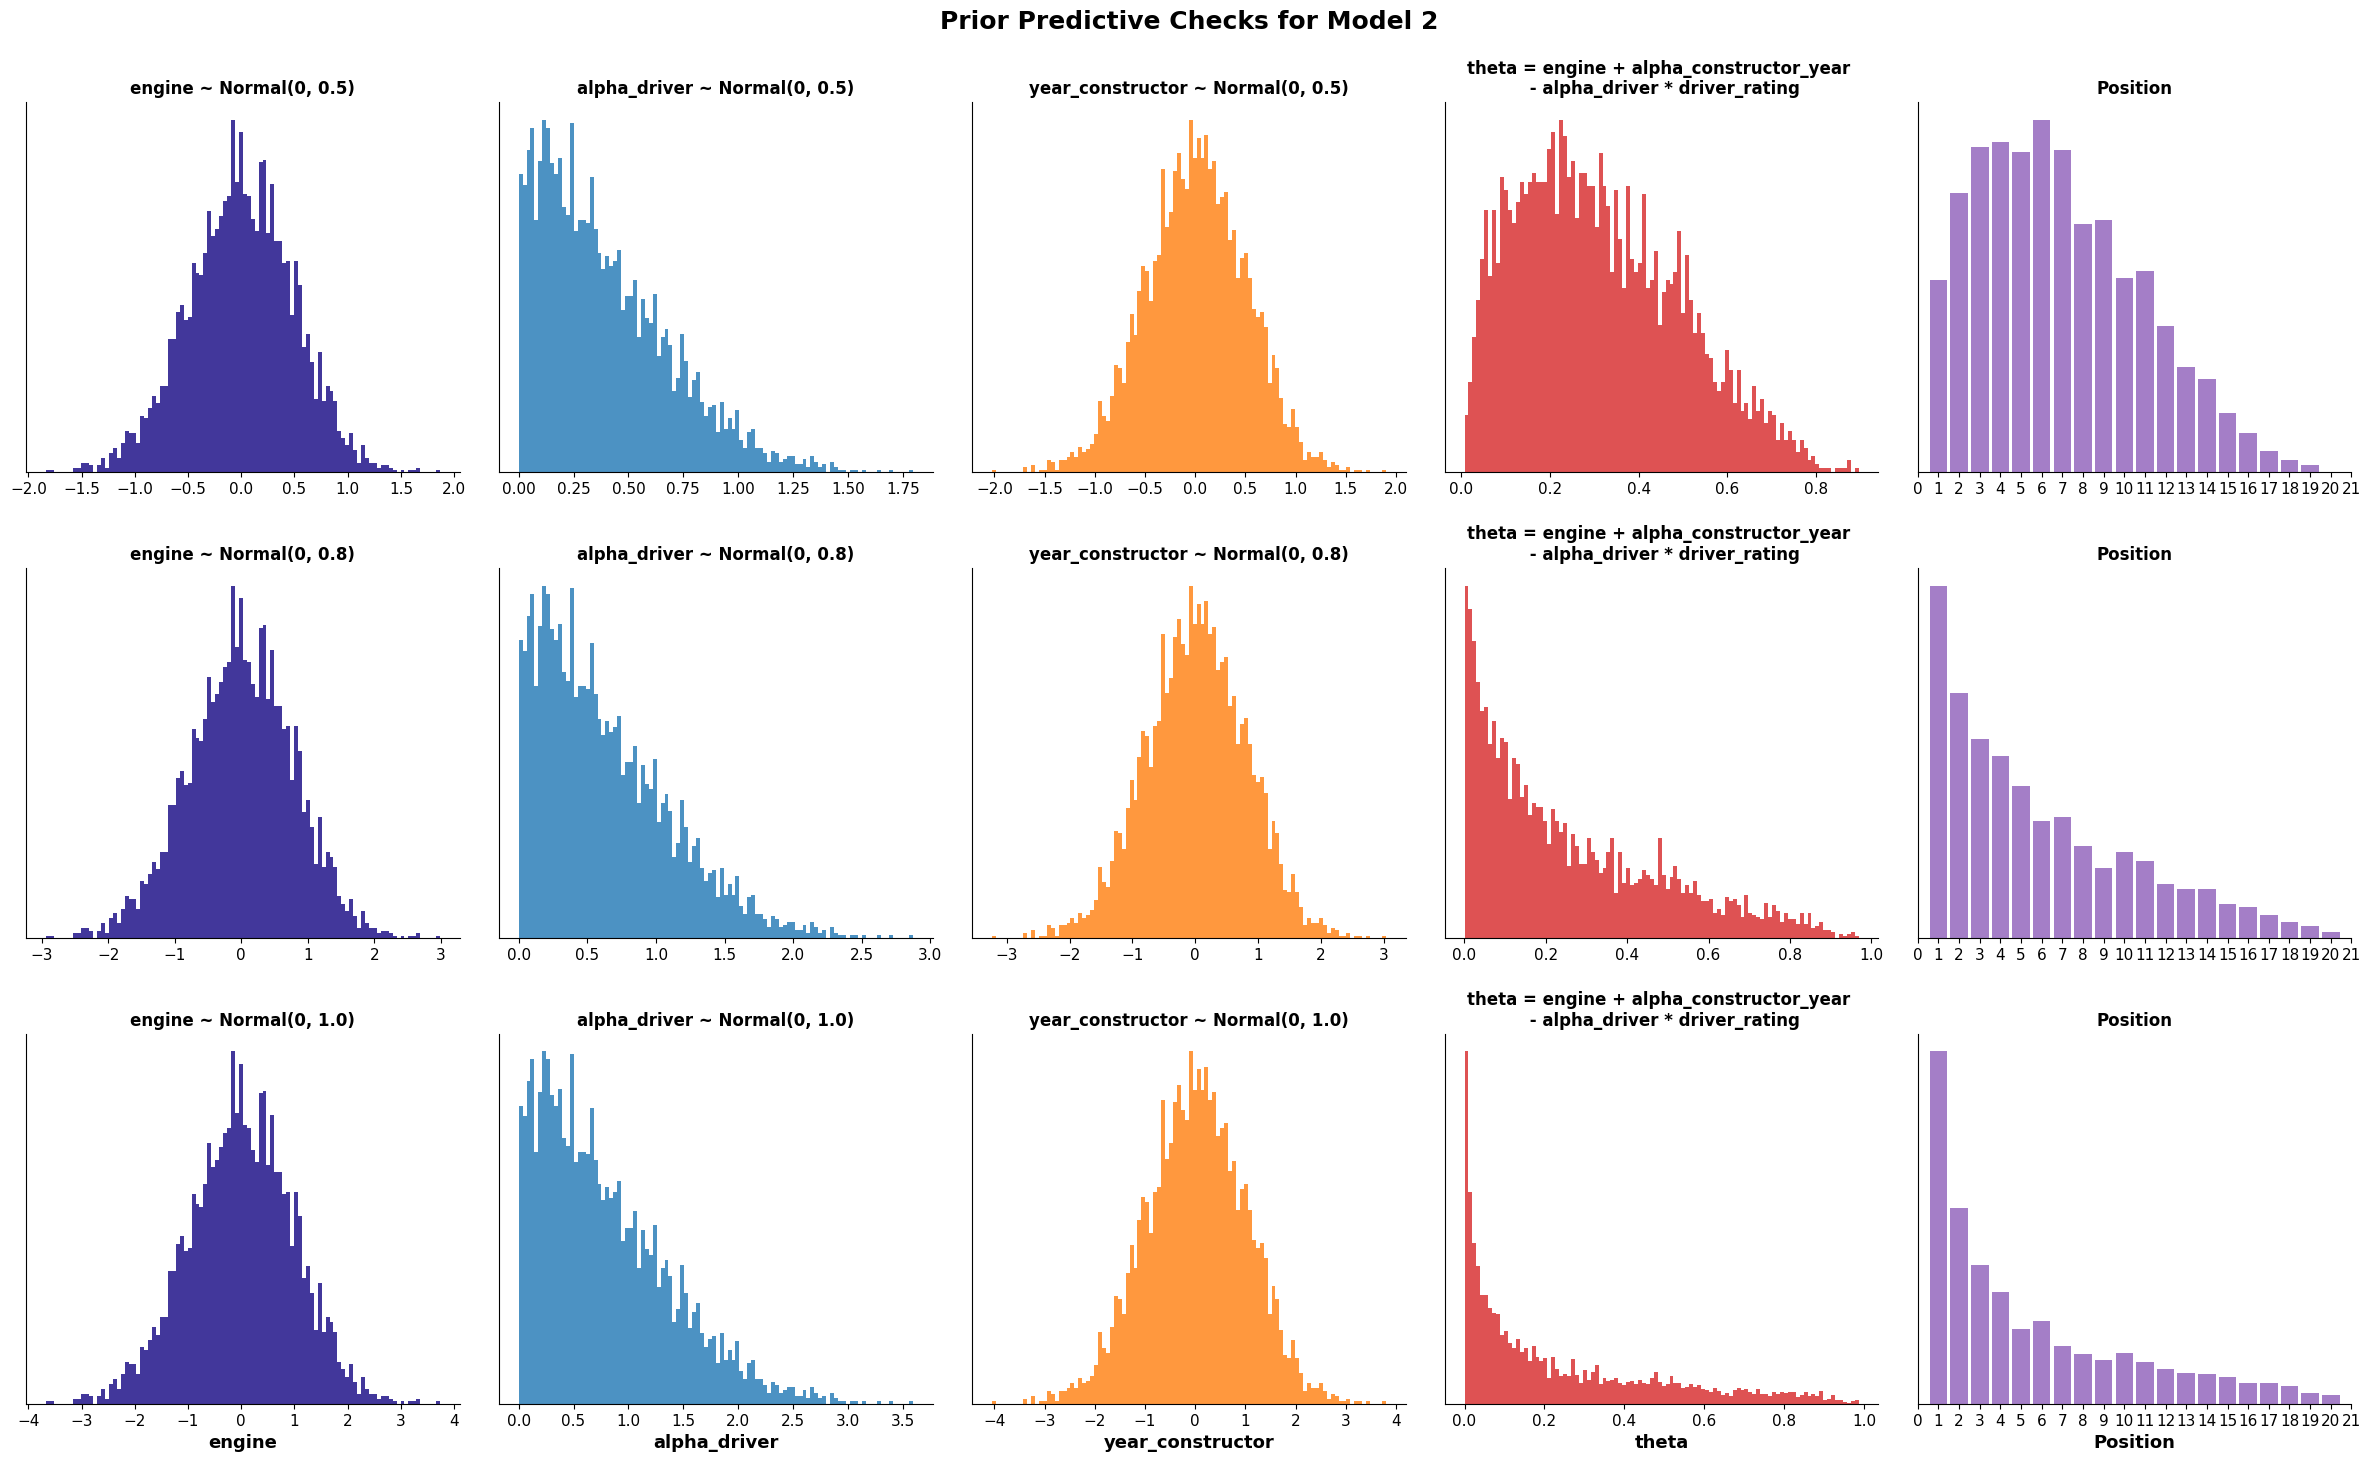

In [21]:
driver_rating = 2.5

draw_plots_ppc_model_2(sigmas, driver_rating)

#### An average driver from the middle of the field.

17:35:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:26 - cmdstanpy - INFO - CmdStan done processing.
17:35:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:26 - cmdstanpy - INFO - CmdStan done processing.


17:35:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:26 - cmdstanpy - INFO - CmdStan done processing.


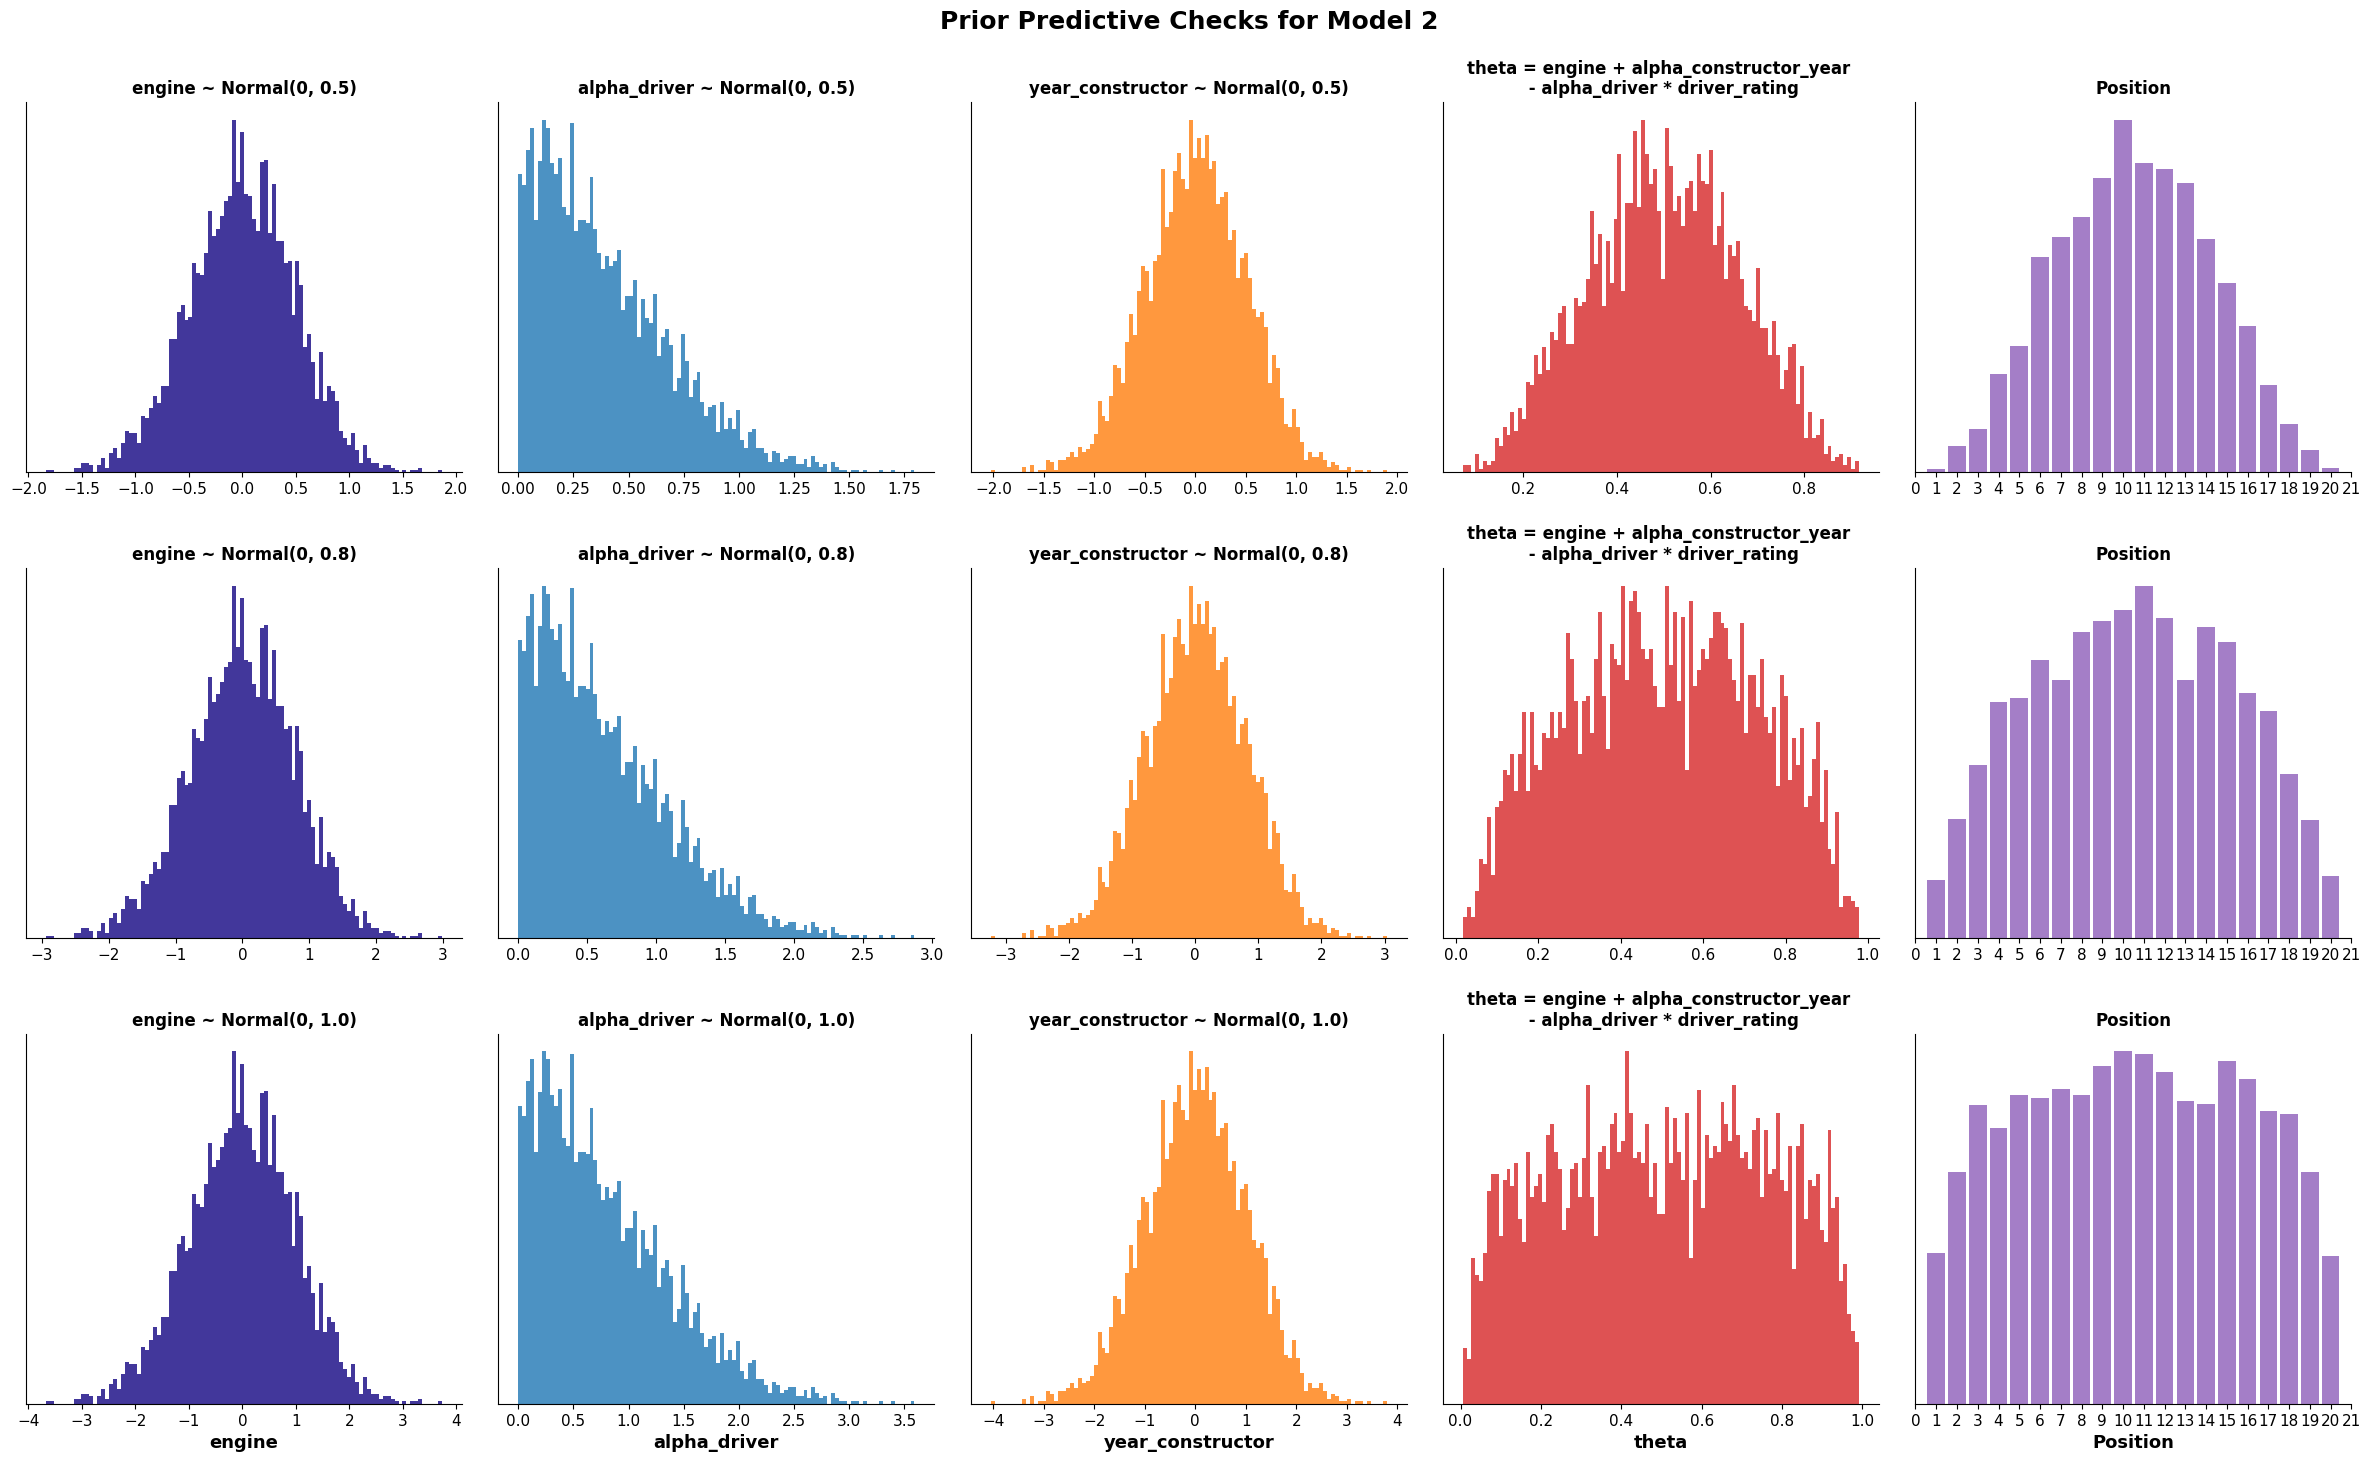

In [22]:
driver_rating = 0

draw_plots_ppc_model_2(sigmas, driver_rating)

#### The driver with the worst results.

17:35:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:29 - cmdstanpy - INFO - CmdStan done processing.


17:35:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:30 - cmdstanpy - INFO - CmdStan done processing.
17:35:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:30 - cmdstanpy - INFO - CmdStan done processing.


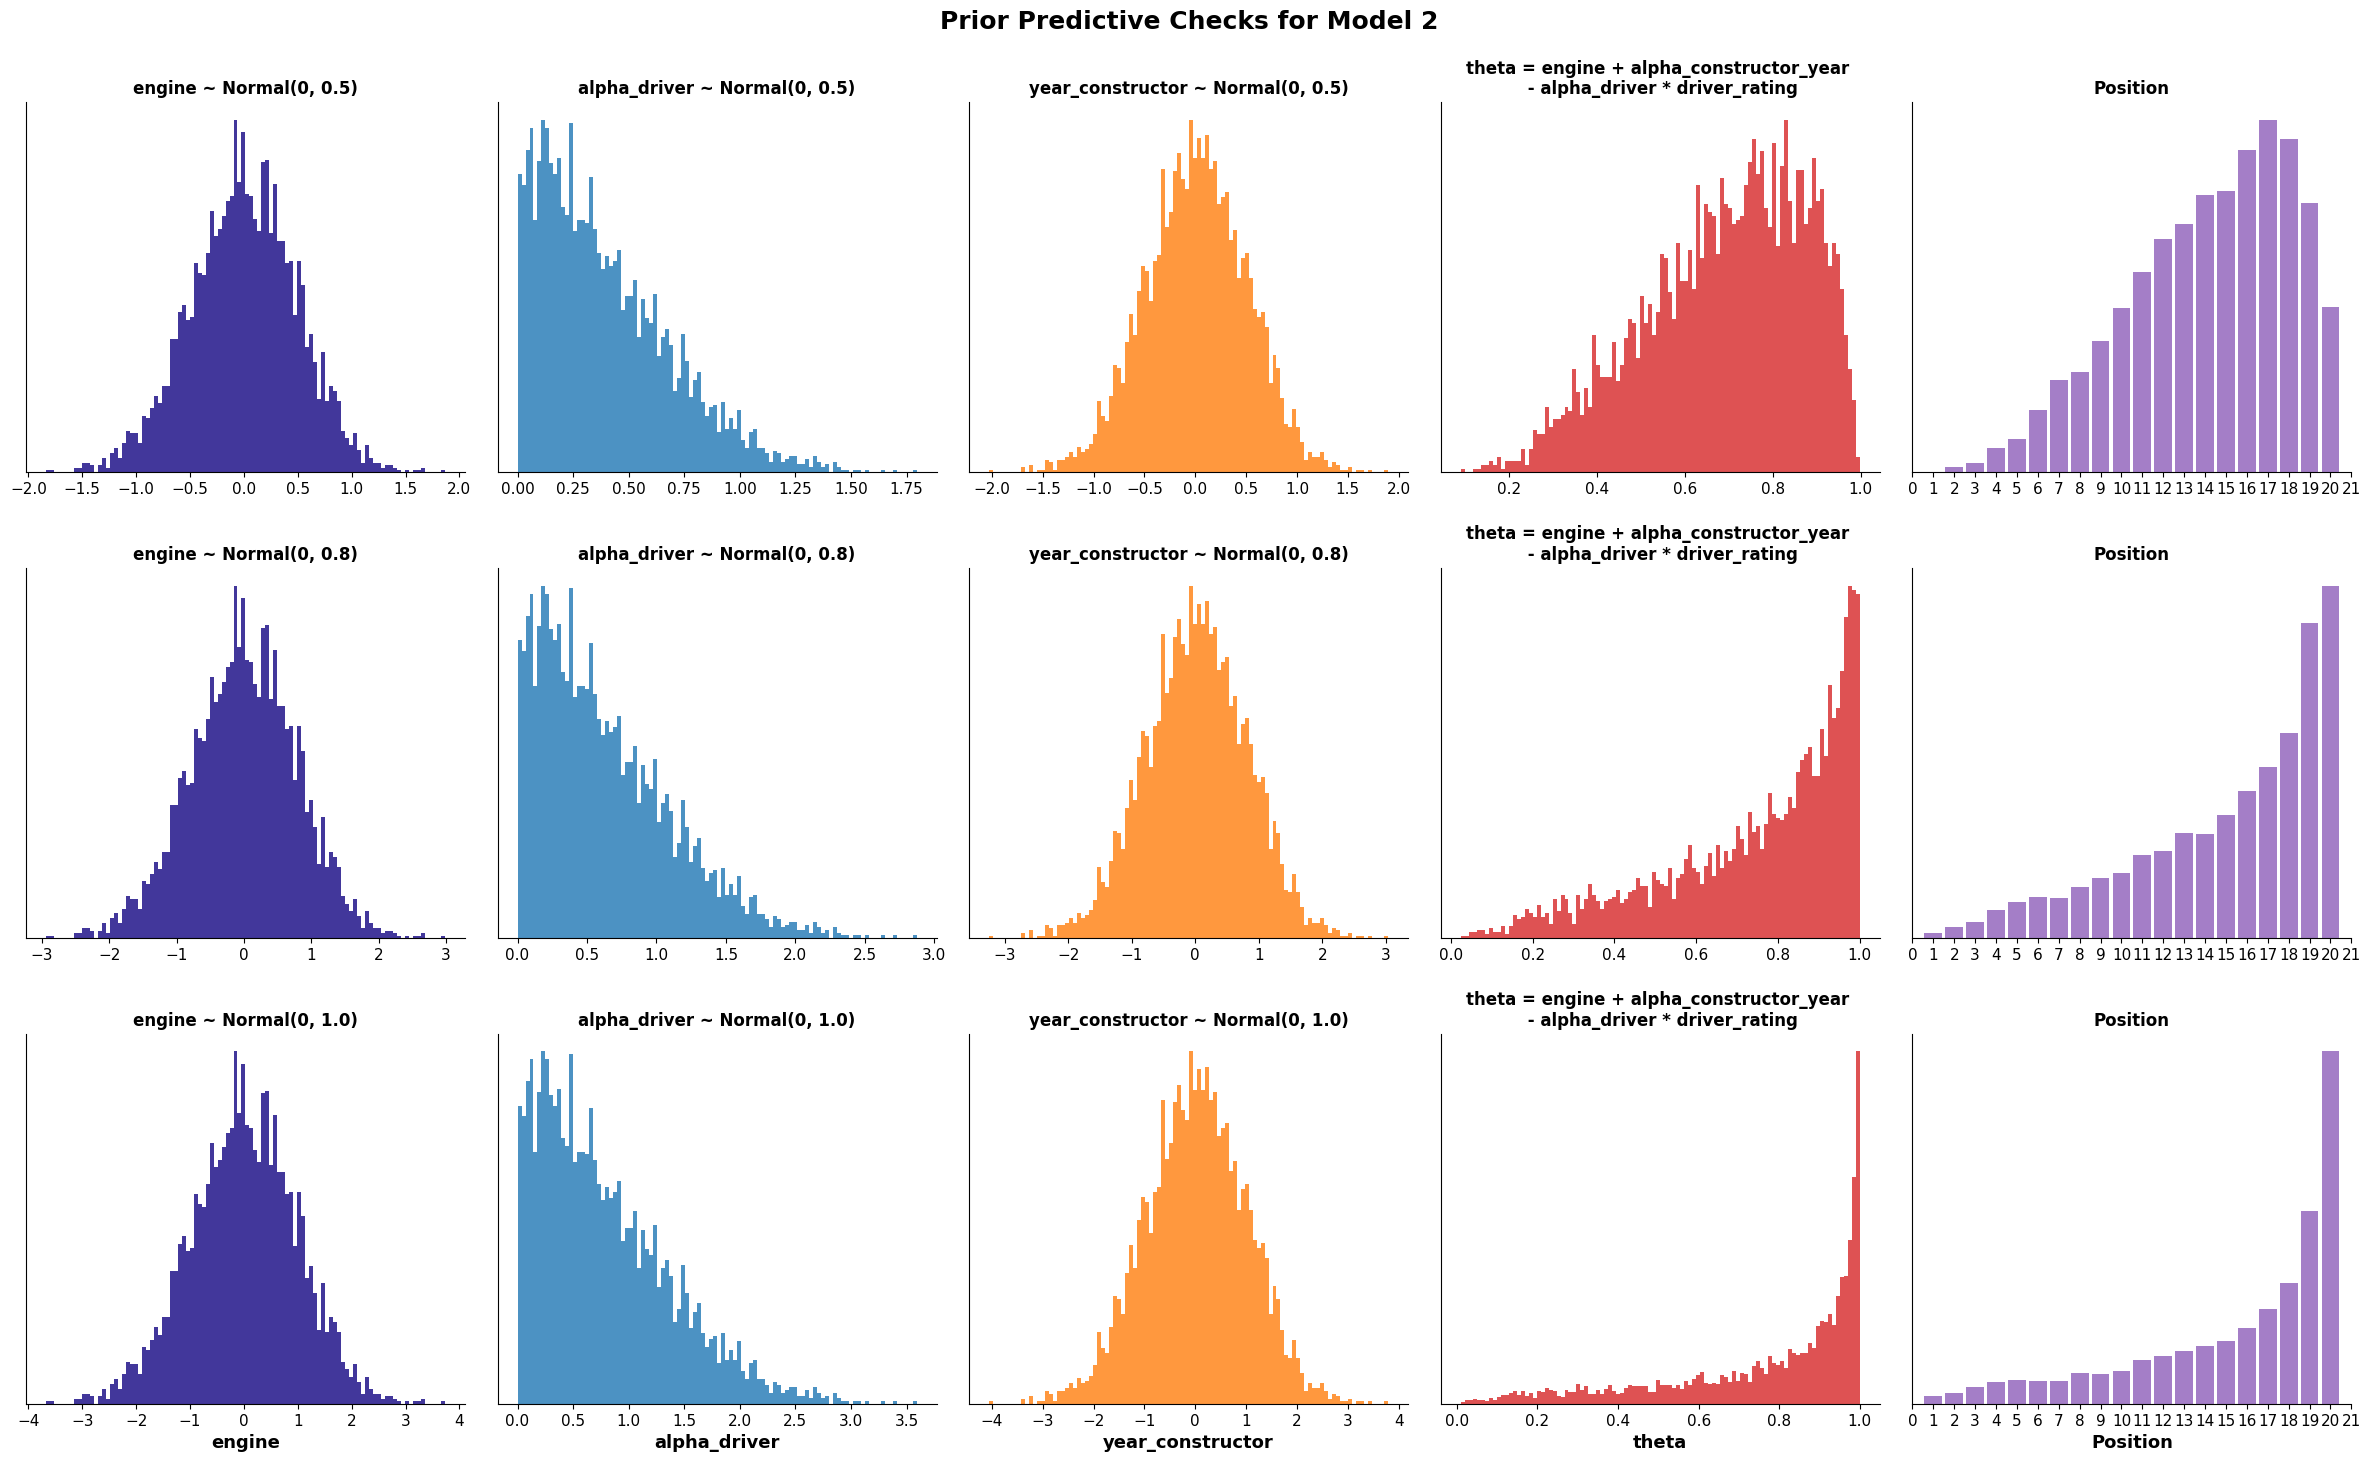

In [23]:
driver_rating = -2.5

draw_plots_ppc_model_2(sigmas, driver_rating)

We choose sigma 0.8 for our model

## Posterior analysis (model 1) [0-4 pts]
- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

There was no issue with sampling.

In [30]:
def plot_post_3(model_fit, drivers_names):
    fig, axes = plt.subplots(1, len(drivers_names), figsize=(5 * len(drivers_names), 4), sharey=True)

    n_bins = np.arange(22) - 0.5

    for d_i, d_name in enumerate(drivers_names):
        ax = axes[d_i]
        driver_id = driver_id_map[d_name]
        results = df[df['DriverId'] == driver_id]
        results_idx = results.index

        ax.hist((results['Position']).tolist(),
                bins=n_bins,
                rwidth=0.9,
                color='cornflowerblue',
                edgecolor='royalblue',
                alpha=0.7,
                density=True,
                label='Observed')

        ax.hist(model_fit.stan_variable('y_hat').T[results_idx].flatten() + 1,
                bins=n_bins,
                rwidth=0.9,
                histtype='step',
                edgecolor='black',
                density=True,
                label='Simulated')

        ax.set_xticks(range(22))
        ax.set_xlim([0, 21])
        ax.set_yticks([])
        ax.set_title(d_name.upper() + '\nfinishing positions (2020-2024)', fontsize=11)
        ax.set_xlabel('Position')
        ax.legend(loc='upper right', fontsize=8)

    fig.tight_layout()
    plt.show()

In [24]:
model_1 = CmdStanModel(stan_file='stan/model_1.stan')

In [25]:
model_1_data = {'N': len(df),
                'C': len([*team_id_map.values()]),
                'D': len([*driver_id_map.values()]),
                'driver_rating': ratings,
                'constructor': teams,                
                'driver': drivers,
                'position': df['Position'] - 1} 

model_1_fit = model_1.sample(data=model_1_data, seed=25062025, iter_warmup=1000)

17:35:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:35:49 - cmdstanpy - INFO - CmdStan done processing.


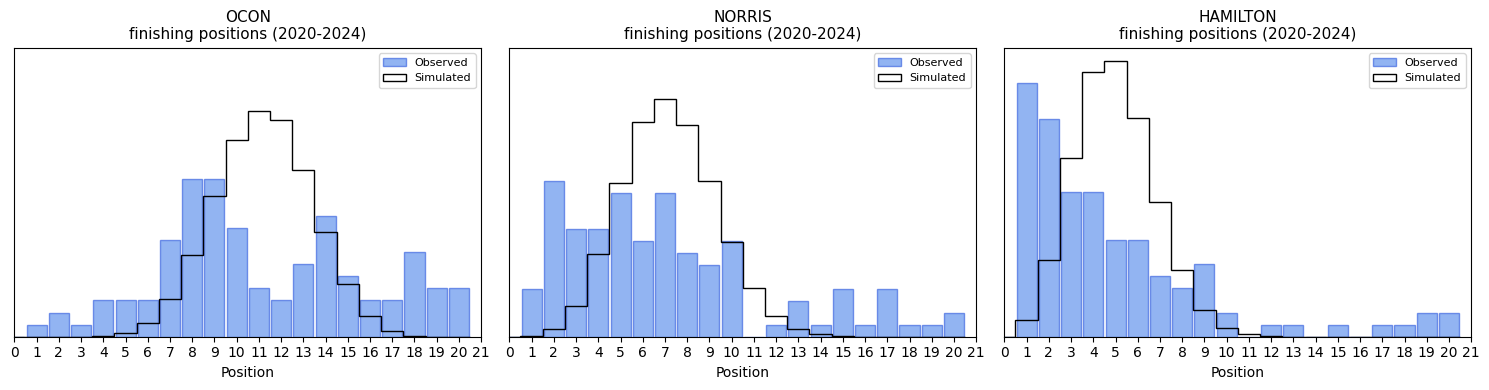

In [31]:
drivers_names = ['ocon', 'norris', 'hamilton']
plot_post_3(model_1_fit, drivers_names)

## Posterior analysis (model 2) [0-4 pts]
- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
 are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [32]:
model_2 = CmdStanModel(stan_file='stan/model_2.stan')

In [33]:
model_2_data = {'N': len(df),
                'C': len([*team_id_map.values()]),
                'E': len([*engine_id_map.values()]),
                'D': len([*driver_id_map.values()]),
                'Y': len([*season_id_map.values()]),
                'driver_rating': ratings_by_year,
                'engine': engines,
                'constructor': teams,                
                'driver': drivers,
                'year': seasons,
                'position': df['Position'] - 1} 

model_2_fit = model_2.sample(data=model_2_data, seed=25062025, iter_warmup=1000)

17:40:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:40:46 - cmdstanpy - INFO - CmdStan done processing.


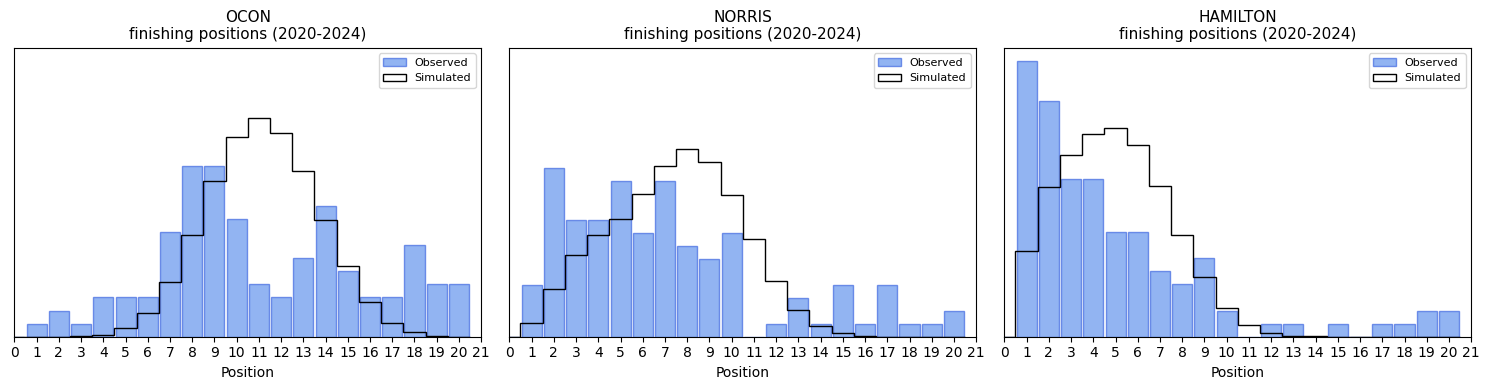

In [34]:
drivers_names = ['ocon', 'norris', 'hamilton']
plot_post_3(model_2_fit, drivers_names)

## Model comaprison [0-4 pts]
- Have models been compared using information criteria [1 pt]
- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]

In [35]:
fit_1 = az.from_cmdstanpy(posterior=model_1_fit,
                          log_likelihood='log_lik',
                          posterior_predictive='y_hat',
                          observed_data=model_1_data['position'])

fit_2 = az.from_cmdstanpy(posterior=model_2_fit,
                          log_likelihood='log_lik',
                          posterior_predictive='y_hat',
                          observed_data=model_2_data['position'])

In [ ]:
dict_compare = {
    'Model 1': fit_1,
    'Model 2': fit_2
}

#### Waic comparison

In [ ]:
waic_compare = az.compare(dict_compare, ic='waic')
print(waic_compare)

In [ ]:
az.plot_compare(waic_compare, figsize=(6, 4))
plt.title('WAIC comparision between Model 1 and Model 2 (higher is better)')
plt.show()

#### Psis-loo comparison

In [ ]:
loo_compare = az.compare(dict_compare, ic='loo')
print(loo_compare)

In [ ]:
az.plot_compare(loo_compare, figsize=(6, 4))
plt.title('LOO comparision between Model 1 and Model 2 (higher is better)')
plt.show()